# Time Series Forecasting with RNNs

Dataset compiled from Max-Planck-Institute for Biogeochemistry: https://www.bgc-jena.mpg.de/wetter/

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

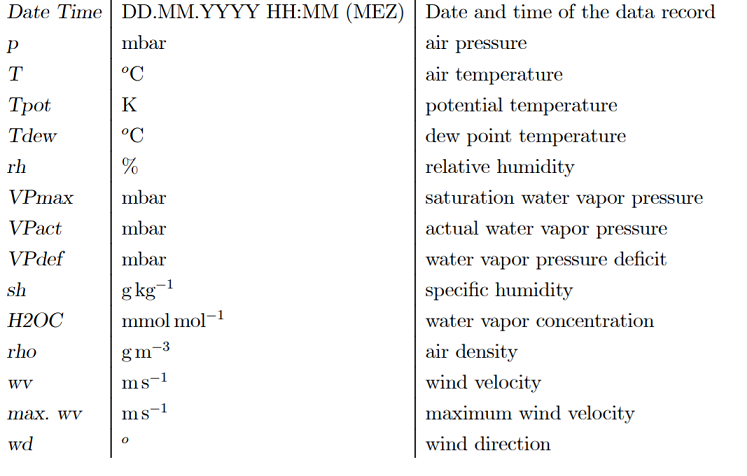

In [2]:
Image("temperature_vars.png", width=600, height=700)

In [3]:
data = pd.read_csv('data/jena_climate_hourly_data.csv', index_col='Date Time')
data.rename(columns={'T (degC)':'T'}, inplace=True)
data.shape

(70091, 14)

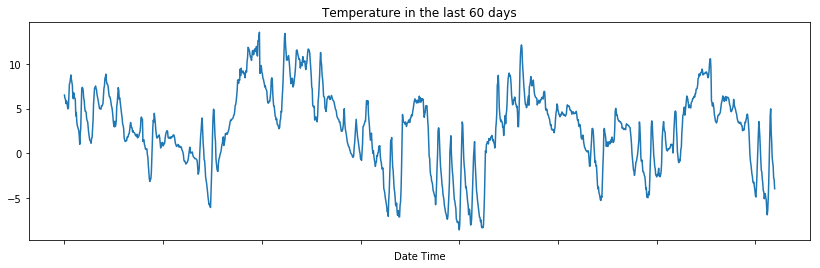

In [4]:
data['T'][-(24*60):].plot(figsize=(14,4))
plt.title("Temperature in the last 60 days");

### Problem:  **Use the previous 4 days of data to predict the temperature 24 hours later**

## 1. Data preparation

In [5]:
## Standarizing the data: so we have all the features in about the same scale
means = data.mean()
stdevs = data.std()
data = (data - means)/stdevs

This is how the (X, y) pairs in this supervised problem look like

In [6]:
X_sample = data[:96].values
y_sample = data.iloc[(96+24)]['T']
print("Input shape:", X_sample.shape, ', Output shape: 1')
(X_sample, y_sample)

Input shape: (96, 14) , Output shape: 1


(array([[  8.71785749e-01,  -2.07760705e+00,  -2.12984274e+00, ...,
          -2.28055525e-02,  -3.08612896e-02,   2.06776985e-01],
        [  8.86141729e-01,  -2.17614227e+00,  -2.22861486e+00, ...,
          -2.21943757e-02,  -3.08612896e-02,   1.79069576e-01],
        [  9.12461026e-01,  -2.16783207e+00,  -2.22273557e+00, ...,
          -2.32639351e-02,  -3.08612896e-02,  -8.76142347e-02],
        ..., 
        [ -4.52553403e-01,  -1.29169961e+00,  -1.24794880e+00, ...,
          -1.25683413e-02,   5.51549912e-03,  -3.46216718e-01],
        [ -4.71694710e-01,  -1.29288678e+00,  -1.24912466e+00, ...,
          -3.55348366e-03,   2.20851832e-03,   4.35363108e-01],
        [ -4.95621343e-01,  -1.29644829e+00,  -1.25030052e+00, ...,
          -4.31745464e-03,   4.88888309e-04,   7.50534884e-01]]),
 -2.7056207027705264)

## 2. Write the input pipeline

In [7]:
periods = 4*24 # 4 days
periods_future = 24
batch_size = 64

In [8]:
def batch_generator(data, periods, periods_future, shuffle, min_index, max_index, batch_size=batch_size):
    if max_index is None:
        max_index = len(data) - periods_future - 1
    i = min_index + periods
    while True:
        if shuffle:
            rows = np.random.randint(low=i, high=max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + periods
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        Xs = np.zeros(shape=(len(rows), periods, data.shape[1]))
        ys = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = np.arange(rows[j] - periods, rows[j])
            Xs[j] = data.iloc[indices].values
            ys[j] = data.iloc[rows[j] + periods_future]['T']
        yield Xs, ys

In [9]:
train_obs = 64000
train_generator = batch_generator(data, periods=periods,
                                  periods_future=periods_future,
                                  shuffle = True,
                                  min_index=0, max_index=train_obs,
                                  batch_size=batch_size)

test_generator = batch_generator(data, periods=periods,
                                  periods_future=periods_future,
                                  shuffle = False,
                                  min_index=0, max_index=None,
                                  batch_size=batch_size)

## 3. Create placeholders to pass values

In [10]:
## Parameters
units_in_cell = 32
n_epochs = 15
learning_rate = 0.001
steps_per_epoch = int(train_obs/batch_size)

In [11]:
## Placeholders
X = tf.placeholder(tf.float32, shape=(batch_size, periods, data.shape[1])) # shape: batch_size x periods x input_features
y = tf.placeholder(tf.float32, shape=batch_size)

## 4. Build the Recurrent Neural Network: using the BasicRNNCell

In [12]:
## Cells and initial state
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=units_in_cell)
rnn_outputs, final_state = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
## An additional dense layer before the final predictions
y_pred = tf.layers.dense(inputs=rnn_outputs[:, -1, :], units=1, activation=None)
# Predictions (one dimensional)
y_pred = tf.squeeze(y_pred)

## 5. Calculate the loss and training operation

In [13]:
loss = tf.reduce_mean(tf.square(y - y_pred))
training_op = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Creating a saver for using our model
saver = tf.train.Saver()

## 6. Train the model

In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        print(epoch+1, end=', ')
        for i in range(steps_per_epoch):
            X_values, y_values = next(train_generator)
            sess.run(training_op, feed_dict={X: X_values, y: y_values})
            
    save_path = saver.save(sess, "./SavedModels/simple-rnn.ckpt")
    predictions = sess.run(y_pred, feed_dict={X: X_values, y:y_values})

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

## 7. Evaluate the results

In [15]:
def temp_to_original_scale(x):
    return stdevs['T']*x + means['T']

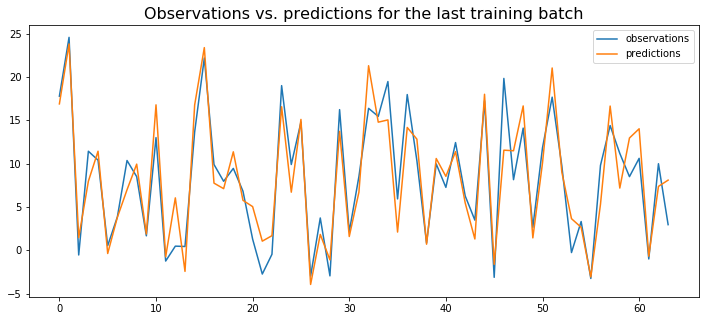

In [16]:
y_values = temp_to_original_scale(y_values)
predictions = temp_to_original_scale(predictions)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(y_values, label='observations')
ax.plot(predictions, label='predictions')
ax.set_title('Observations vs. predictions for the last training batch', size=16)
plt.legend();

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./SavedModels/simple-rnn.ckpt")
    batchs_pred = 10
    y_true_test = []
    y_pred_test= []
    for i in range(batchs_pred):
        X_values, y_values = next(test_generator)
        y_true_test.append(temp_to_original_scale(y_values))
        predictions = sess.run(y_pred, feed_dict={X: X_values, y:y_values})
        y_pred_test.append(temp_to_original_scale(predictions))

y_true_test = np.array(y_true_test).reshape(batchs_pred*batch_size)
y_pred_test = np.array(y_pred_test).reshape(batchs_pred*batch_size)

INFO:tensorflow:Restoring parameters from ./SavedModels/simple-rnn.ckpt


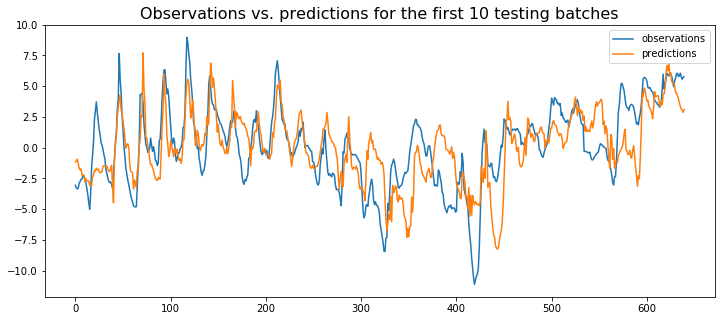

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(y_true_test, label='observations')
ax.plot(y_pred_test, label='predictions')
ax.set_title('Observations vs. predictions for the first 10 testing batches', size=16)
plt.legend();

#### Excercise: calculate the MSE in the testing set